In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from layers import InputToCx, CxD2NNIntensity, CxD2NNFaradayRotation, CxMO, FreeSpacePropagation, ImageResize

plt.rcParams["font.size"]=18

In [38]:
class Polarizer(tf.keras.layers.Layer):
    def __init__(self, output_dim, phi=0.0, trainable=False):
        super(Polarizer, self).__init__()
        self.output_dim = output_dim
        self.phi = self.add_weight(shape=(), initializer=tf.initializers.Constant(value=phi))
        self.trainable = trainable

    def call(self, x):
        x_rcp = tf.keras.layers.Lambda(lambda x: x[:, 0, 0:2, :, :])(x)
        y_rcp = tf.keras.layers.Lambda(lambda x: x[:, 0, 2:4, :, :])(x)
        x_lcp = tf.keras.layers.Lambda(lambda x: x[:, 1, 0:2, :, :])(x)
        y_lcp = tf.keras.layers.Lambda(lambda x: x[:, 1, 2:4, :, :])(x)

        rcp_x = tf.cos(self.phi) ** 2 * x_rcp + tf.sin(2 * self.phi) / 2 * y_rcp
        rcp_y = tf.sin(2 * self.phi) / 2 * x_rcp + tf.sin(self.phi) ** 2 * y_rcp

        lcp_x = tf.cos(self.phi) ** 2 * x_lcp + tf.sin(2 * self.phi) / 2 * y_lcp
        lcp_y = tf.sin(2 * self.phi) / 2 * x_lcp + tf.sin(self.phi) ** 2 * y_lcp

        rcp = tf.concat([rcp_x, rcp_y], axis=1)
        lcp = tf.concat([lcp_x, lcp_y], axis=1)

        cmpx = tf.stack([rcp, lcp], axis=1)

        return cmpx

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

In [41]:
inputs = tf.keras.Input((28, 28))
x = ImageResize((100, 100))(inputs)
x = InputToCx((100, 100))(x)
x = Polarizer((100, 100), phi=np.pi/2, trainable=False)(x)
x = CxD2NNIntensity((100, 100), normalization=None)(x)

model = tf.keras.Model(inputs, x)
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resize_16 (ImageResiz  (None, 100, 100)         0         
 e)                                                              
                                                                 
 input_to_cx_15 (InputToCx)  (None, 2, 4, 100, 100)    0         
                                                                 
 polarizer_17 (Polarizer)    (None, 2, 4, 100, 100)    1         
                                                                 
 cx_d2nn_intensity_15 (CxD2N  (None, 100, 100)         0         
 NIntensity)                                                     
                                                                 
Total params: 1
Trainable params: 0
Non-trainable params: 

2022-03-21 13:54:54.849910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


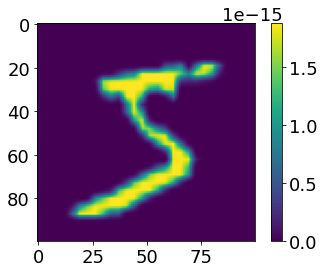

In [42]:
image = np.ones((1, 28, 28))
pred = model.predict(x_train[0:10,:,:])

plt.imshow(pred[0,:,:])
plt.colorbar()